In [1]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch
import keras
import os
import cv2
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import load_dataset

In [2]:
MODEL_PATH = "captcha_model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

In [3]:
try:
    # Try to load existing encoder
    with open("label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    print("Loaded existing label encoder")
except FileNotFoundError:
    # Create and fit a new encoder
    print("Creating new label encoder")
    label_encoder = LabelEncoder()
    
    # Get all unique labels from your dataset
    samples_dir = "samples"
    labels = []
    for file in os.listdir(samples_dir):
        if file.endswith((".png", ".jpg")):
            # Extract label from filename (assuming filename is the label)
            label = file.split('.')[0]
            labels.append(label)
    
    # Fit the encoder
    label_encoder.fit(labels)
    
    # Save the encoder for future use
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)
    print("Label encoder saved")

Loaded existing label encoder


In [4]:
def load_images(folder="samples", max_images=20):
    image_files = [f for f in os.listdir(folder) if f.endswith((".png", ".jpg"))]
    if not image_files:
        print("No images found in samples folder")
        return None, None
    
    # Limit the number of images to process
    image_files = image_files[:max_images]
    
    images = []
    labels = []
    
    for file in image_files:
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (200, 50))
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)  # Shape: (50, 200, 1)
        
        true_label = file.split('.')[0]
        label_idx = label_encoder.transform([true_label])[0]
        
        images.append(img)
        labels.append(label_idx)
    
    return np.array(images), np.array(labels)

In [5]:
nb_classes = len(label_encoder.classes_)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

classifier = TensorFlowV2Classifier(
    clip_values=(0, 1),
    model=model,
    nb_classes=nb_classes,
    input_shape=(50, 200, 1),
    loss_object=loss_object,
)

In [6]:
test_images, test_labels = load_images()

In [7]:
clean_preds = model.predict(test_images)
clean_accuracy = np.mean(np.argmax(clean_preds, axis=1) == test_labels)
print(f"Clean accuracy: {clean_accuracy:.4f}")

1/1 [==============================] - 0s 444ms/step
Clean accuracy: 1.0000


In [8]:
eps_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
results = []

In [9]:
for eps in eps_values:
    # PGD attack parameters
    attack_pgd = ProjectedGradientDescent(
        estimator=classifier,
        eps=eps,
        eps_step=eps/10,  # Step size for each iteration
        max_iter=40,      # Number of iterations
        targeted=False,   # Untargeted attack
        num_random_init=1 # Number of random initializations
    )
    
    test_images_adv = attack_pgd.generate(x=test_images)
    
    # Evaluate on adversarial examples
    adv_preds = model.predict(test_images_adv)
    adv_accuracy = np.mean(np.argmax(adv_preds, axis=1) == test_labels)
    
    results.append((eps, adv_accuracy))
    print(f"Epsilon: {eps}, Adversarial Accuracy: {adv_accuracy:.4f}")

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 62ms/step
Epsilon: 0.01, Adversarial Accuracy: 1.0000


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 54ms/step
Epsilon: 0.05, Adversarial Accuracy: 0.2000


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 53ms/step
Epsilon: 0.1, Adversarial Accuracy: 0.0000


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 54ms/step
Epsilon: 0.15, Adversarial Accuracy: 0.0000


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 58ms/step
Epsilon: 0.2, Adversarial Accuracy: 0.0000


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 56ms/step
Epsilon: 0.25, Adversarial Accuracy: 0.0000


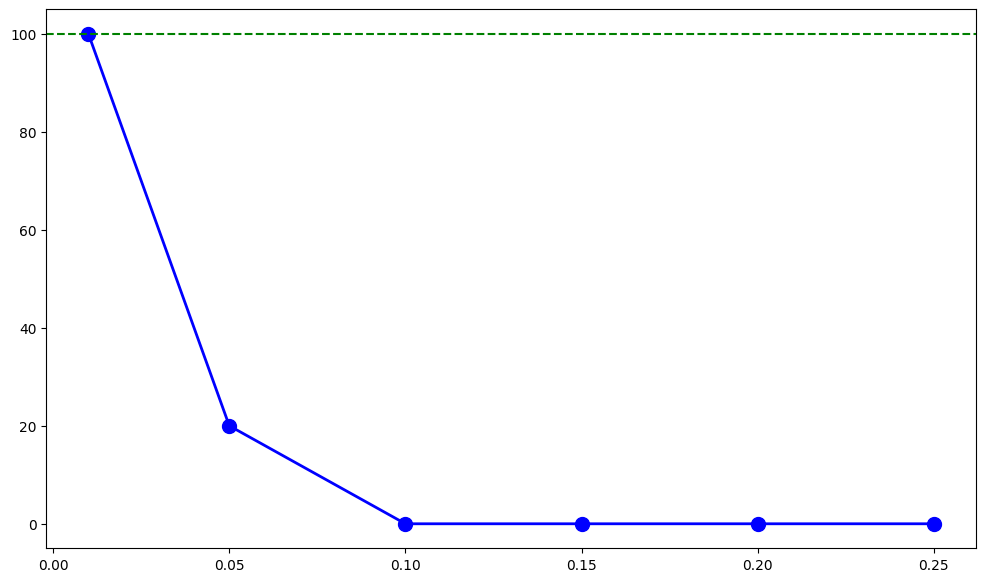

In [10]:
plt.figure(figsize=(12, 7))
eps_values = [r[0] for r in results]
acc_values = [r[1] for r in results]

# Convert accuracy to percentage
acc_percentage = [acc * 100 for acc in acc_values]
clean_accuracy_percentage = clean_accuracy * 100

# Create the line plot
plt.plot(eps_values, acc_percentage, 'o-', linewidth=2, markersize=10, color='blue')
plt.axhline(y=clean_accuracy_percentage, color='green', linestyle='--', 
            label=f'Clean Accuracy: {clean_accuracy_percentage:.2f}%')

C:\Users\palla\AppData\Local\Temp\ipykernel_31884\4100769810.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


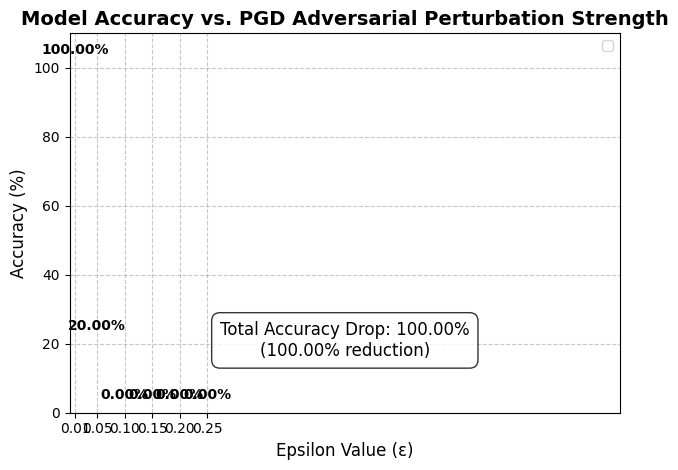

In [11]:
for i, (eps, acc_pct) in enumerate(zip(eps_values, acc_percentage)):
    plt.annotate(f'{acc_pct:.2f}%', 
                 xy=(eps, acc_pct),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 fontweight='bold')

# Add a text box showing the drop in accuracy
initial_acc = acc_percentage[0]
final_acc = acc_percentage[-1]
drop_percentage = initial_acc - final_acc
drop_ratio = (drop_percentage / initial_acc) * 100

plt.text(0.5, 0.15, 
         f'Total Accuracy Drop: {drop_percentage:.2f}%\n({drop_ratio:.2f}% reduction)', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
         ha='center',
         fontsize=12)

# Enhance the plot appearance
plt.xlabel('Epsilon Value (ε)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracy vs. PGD Adversarial Perturbation Strength', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(eps_values)
plt.ylim(0, max(acc_percentage) * 1.1)  # Add some space at the top for labels

plt.tight_layout()
plt.show()

In [12]:
epsilon_values = [0.05, 0.1, 0.2, 0.25]  # Different epsilon values to analyze

# Find the maximum value across all confusion matrices to use a consistent color scale
max_value = 0
all_cms = []

for epsilon in epsilon_values:
    attack_pgd = ProjectedGradientDescent(
        estimator=classifier,
        eps=epsilon,
        eps_step=epsilon/10,
        max_iter=40,
        targeted=False,
        num_random_init=1
    )
    test_images_adv = attack_pgd.generate(x=test_images)
    
    clean_preds = np.argmax(model.predict(test_images), axis=1)
    adv_preds = np.argmax(model.predict(test_images_adv), axis=1)
    
    cm = confusion_matrix(clean_preds, adv_preds)
    all_cms.append(cm)
    max_value = max(max_value, np.max(cm))

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 52ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 52ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 63ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 44ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 44ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 71ms/step


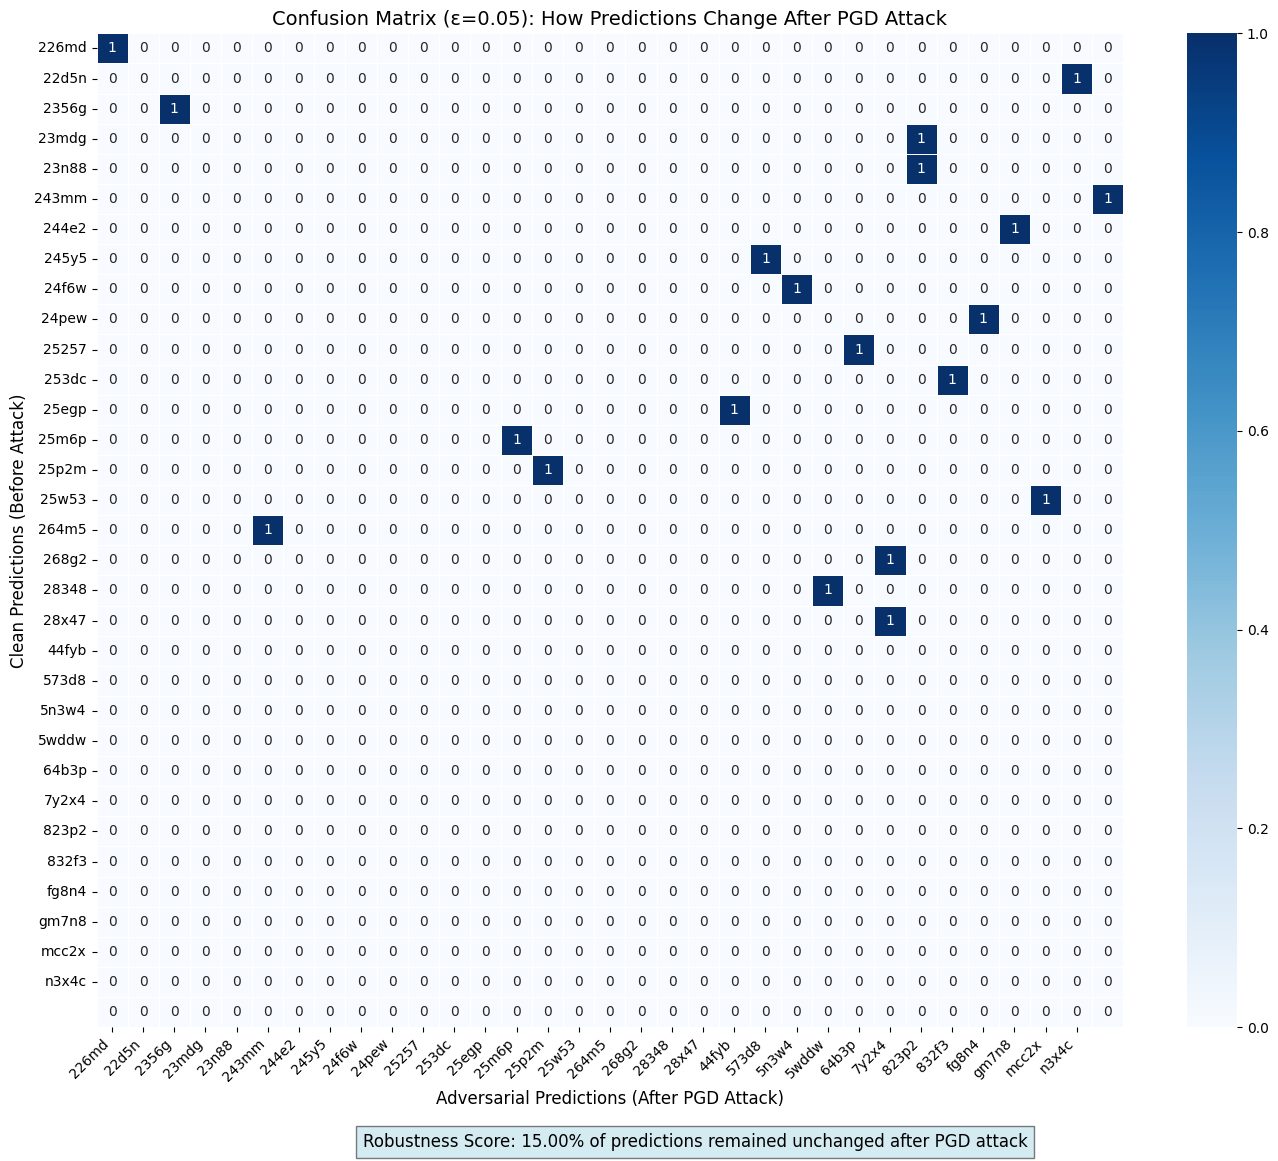

1/1 [==============================] - 0s 59ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 69ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 55ms/step


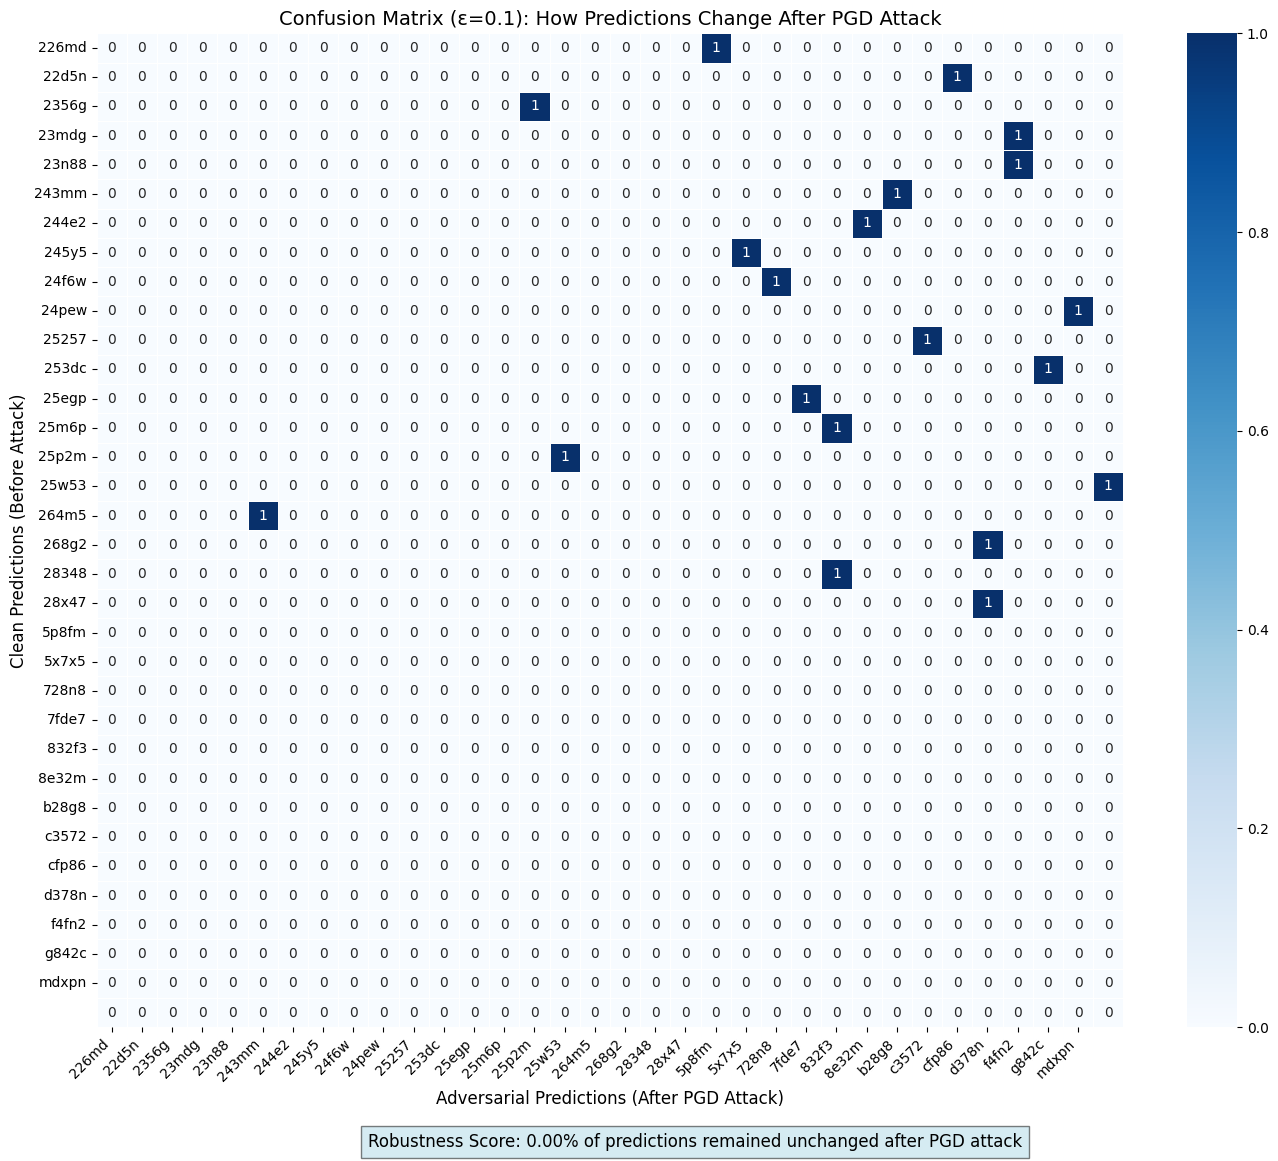

1/1 [==============================] - 0s 55ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 64ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 85ms/step


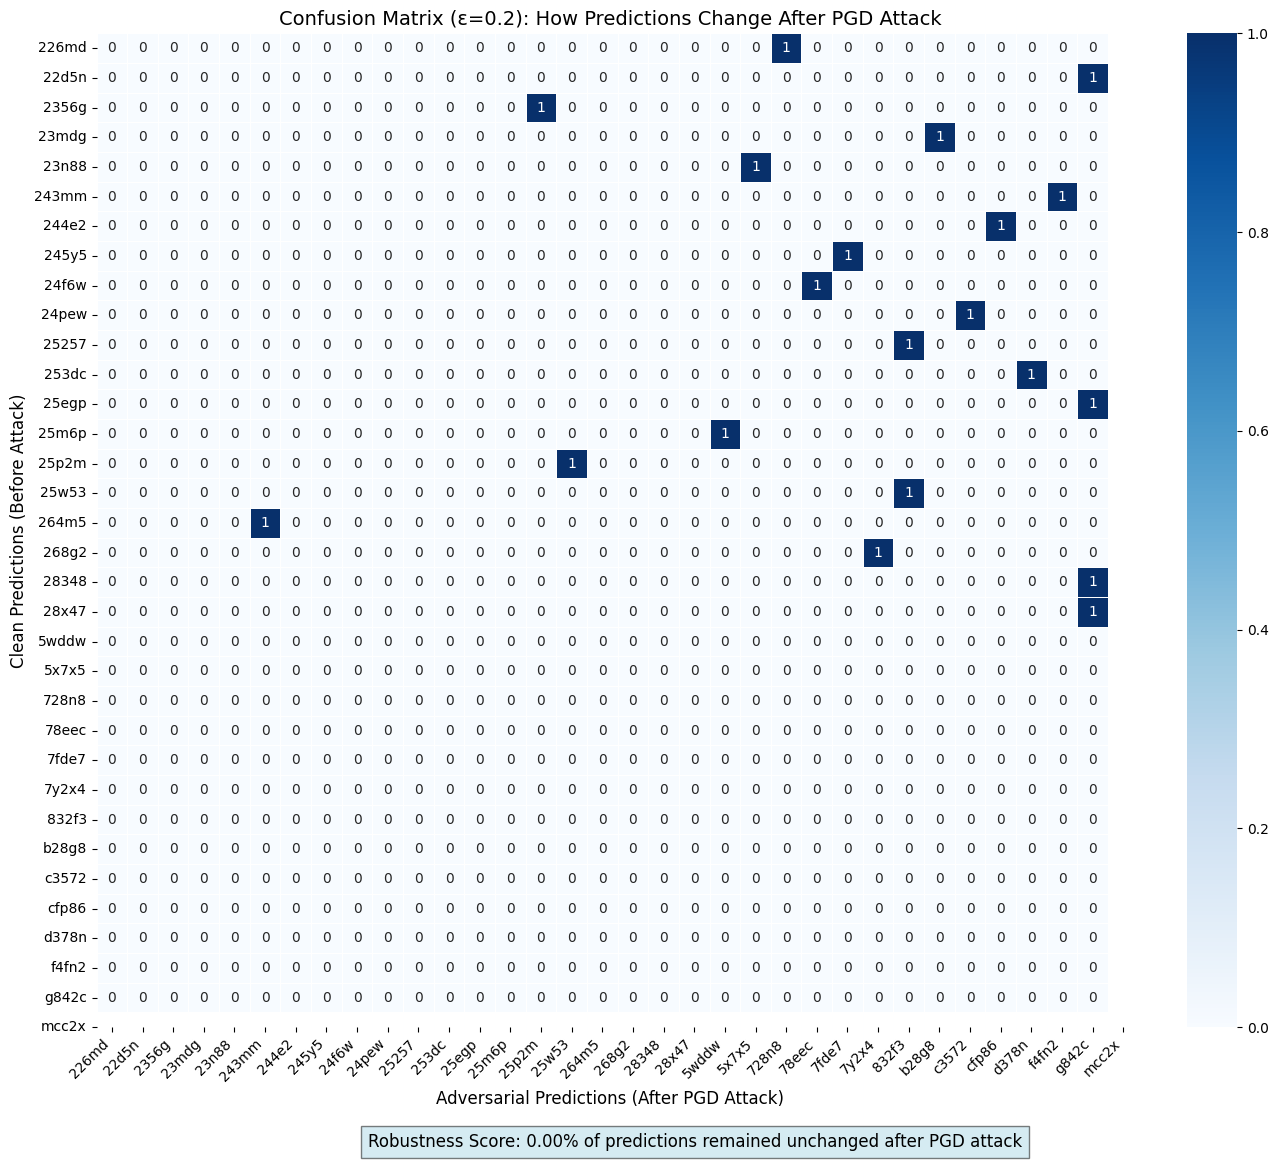

1/1 [==============================] - 0s 50ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 65ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 60ms/step


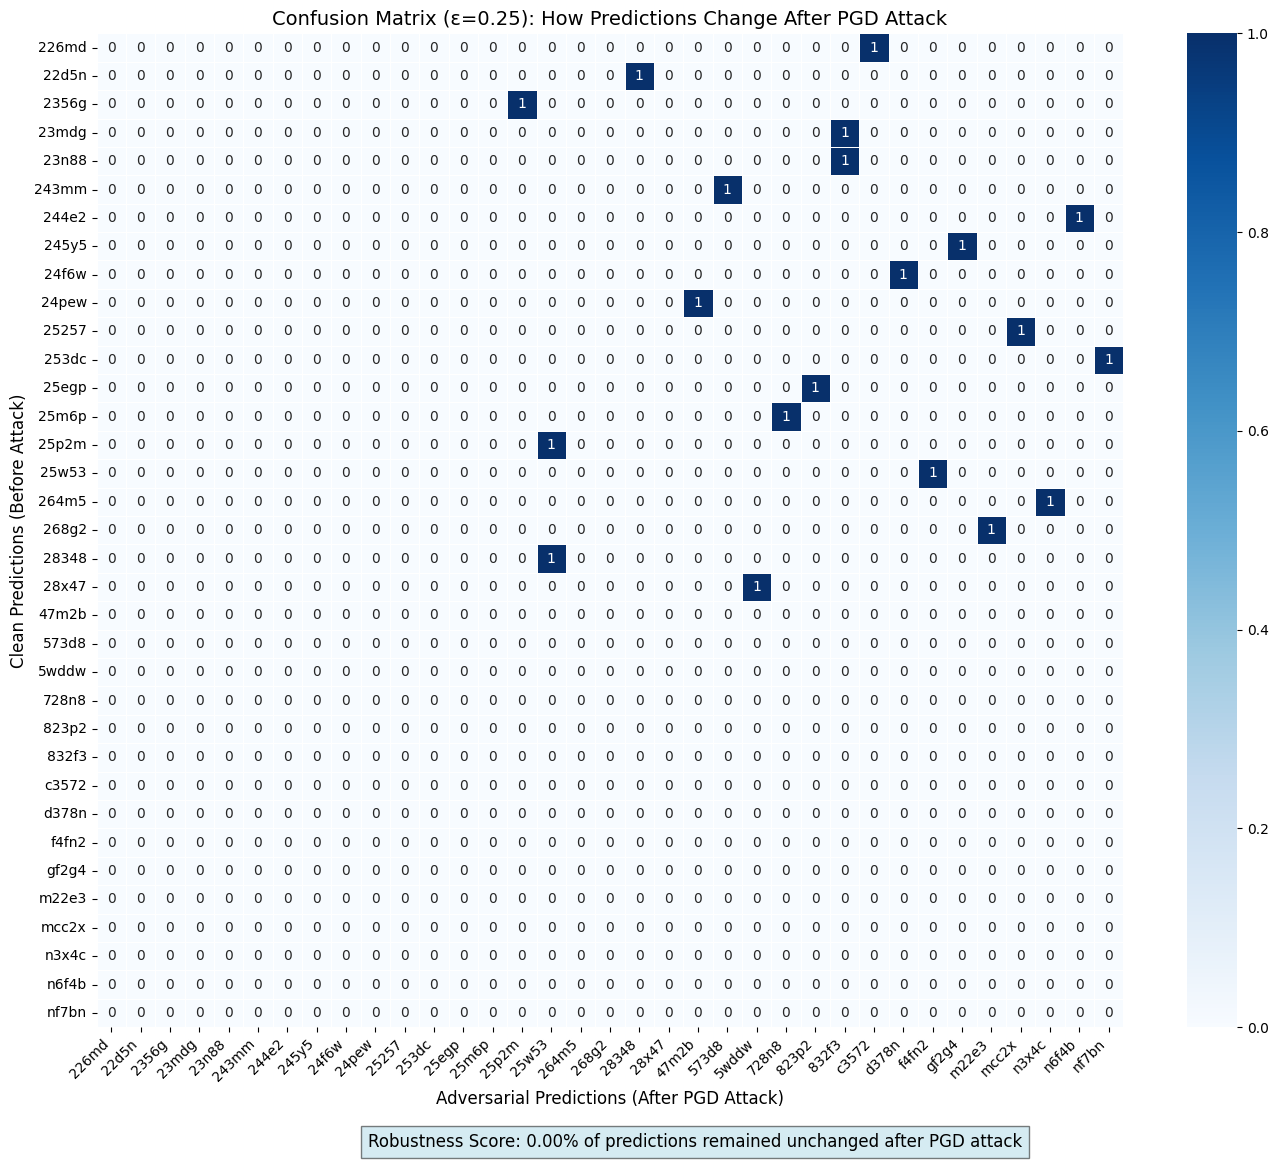

In [13]:
for idx, epsilon in enumerate(epsilon_values):
    plt.figure(figsize=(14, 12))
    
    cm = all_cms[idx]
    
    # Get unique class labels for better visualization
    unique_labels = sorted(set(np.argmax(model.predict(test_images), axis=1)) | 
                          set(np.argmax(model.predict(attack_pgd.generate(x=test_images)), axis=1)))
    class_names = [label_encoder.inverse_transform([i])[0] for i in unique_labels]
    
    # Create a more informative heatmap with consistent color scaling
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                linewidths=0.5, vmin=0, vmax=max_value)
    
    # Rotate the tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add descriptive labels
    plt.xlabel('Adversarial Predictions (After PGD Attack)', fontsize=12)
    plt.ylabel('Clean Predictions (Before Attack)', fontsize=12)
    plt.title(f'Confusion Matrix (ε={epsilon}): How Predictions Change After PGD Attack', fontsize=14)
    
    # Calculate robustness score
    attack_pgd = ProjectedGradientDescent(
        estimator=classifier,
        eps=epsilon,
        eps_step=epsilon/10,
        max_iter=40,
        targeted=False,
        num_random_init=1
    )
    clean_preds = np.argmax(model.predict(test_images), axis=1)
    adv_preds = np.argmax(model.predict(attack_pgd.generate(x=test_images)), axis=1)
    correct_predictions = np.sum(clean_preds == adv_preds)
    total_predictions = len(clean_preds)
    robustness_score = correct_predictions / total_predictions * 100
    
    # Add robustness score to the plot
    plt.figtext(0.5, 0.01, 
               f"Robustness Score: {robustness_score:.2f}% of predictions remained unchanged after PGD attack",
               ha="center", fontsize=12, bbox={"facecolor":"lightblue", "alpha":0.5, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


1/1 [==============================] - 0s 28ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 32ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 27ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 34ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 24ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 41ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 28ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 37ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 38ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 47ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 50ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 32ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 31ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 36ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 35ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 29ms/step


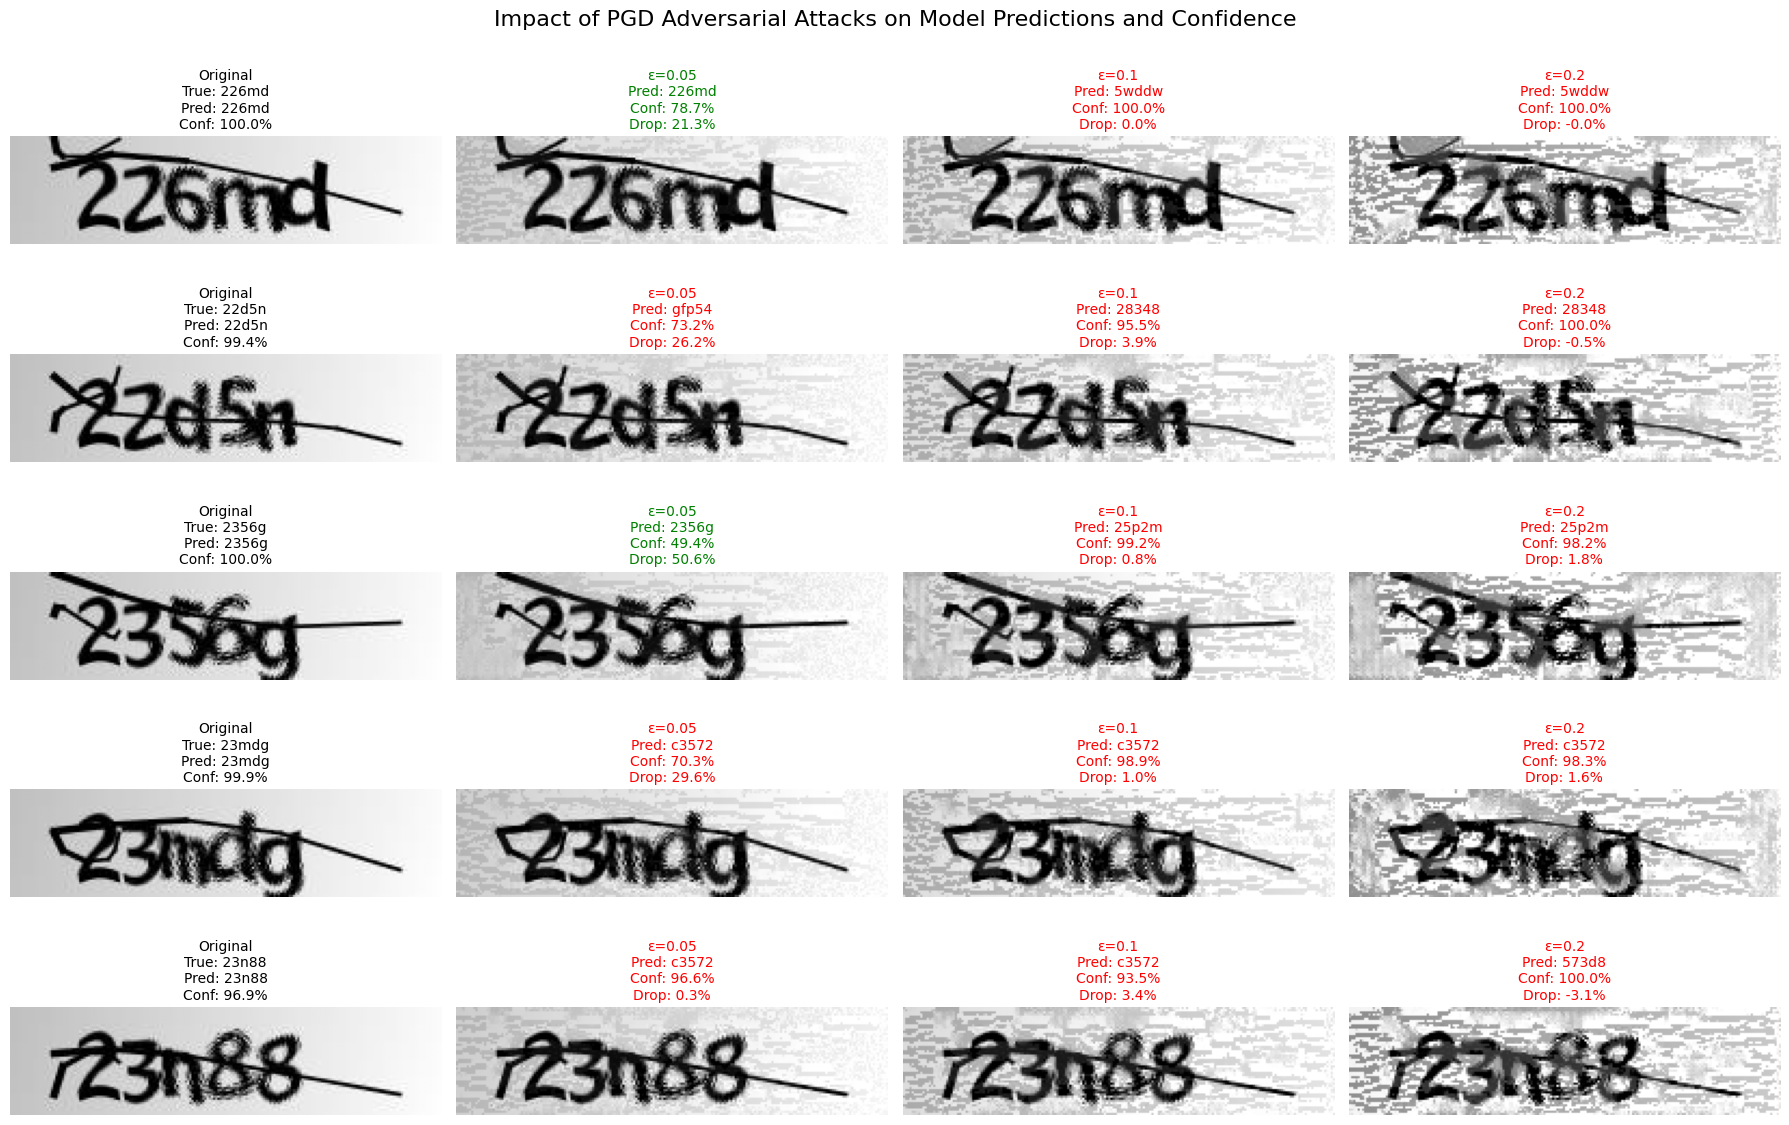

In [14]:
plt.figure(figsize=(18, 12))
n_examples = min(5, len(test_images))

# Select a few epsilon values to compare
eps_to_compare = [0.05, 0.1, 0.2]
n_eps = len(eps_to_compare)

# For each test image
for i in range(n_examples):
    # Original image (first column)
    plt.subplot(n_examples, n_eps + 1, i * (n_eps + 1) + 1)
    plt.imshow(np.squeeze(test_images[i]), cmap='gray')
    
    # Get true label and clean prediction
    true_label = label_encoder.inverse_transform([test_labels[i]])[0]
    clean_pred = model.predict(np.expand_dims(test_images[i], axis=0))
    pred_idx = np.argmax(clean_pred)
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = clean_pred[0][pred_idx] * 100
    
    plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%", fontsize=10)
    plt.axis('off')
    
    # For each epsilon value
    for j, eps in enumerate(eps_to_compare):
        # Create adversarial example with PGD
        attack_pgd = ProjectedGradientDescent(
            estimator=classifier,
            eps=eps,
            eps_step=eps/10,
            max_iter=40,
            targeted=False,
            num_random_init=1
        )
        adv_image = attack_pgd.generate(x=np.expand_dims(test_images[i], axis=0))
        
        # Display adversarial image
        plt.subplot(n_examples, n_eps + 1, i * (n_eps + 1) + j + 2)
        plt.imshow(np.squeeze(adv_image), cmap='gray')
        
        # Get prediction and confidence
        adv_pred = model.predict(adv_image)
        adv_pred_idx = np.argmax(adv_pred)
        adv_pred_label = label_encoder.inverse_transform([adv_pred_idx])[0]
        adv_confidence = adv_pred[0][adv_pred_idx] * 100
        
        # Calculate confidence drop
        conf_drop = confidence - adv_confidence
        
        # Set title color based on whether prediction changed
        title_color = 'red' if adv_pred_label != pred_label else 'green'
        
        plt.title(f"ε={eps}\nPred: {adv_pred_label}\nConf: {adv_confidence:.1f}%\nDrop: {conf_drop:.1f}%", 
                 color=title_color, fontsize=10)
        plt.axis('off')

plt.suptitle("Impact of PGD Adversarial Attacks on Model Predictions and Confidence", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


1/1 [==============================] - 0s 39ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 31ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 30ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 32ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 28ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 27ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 27ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 26ms/step


PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 30ms/step


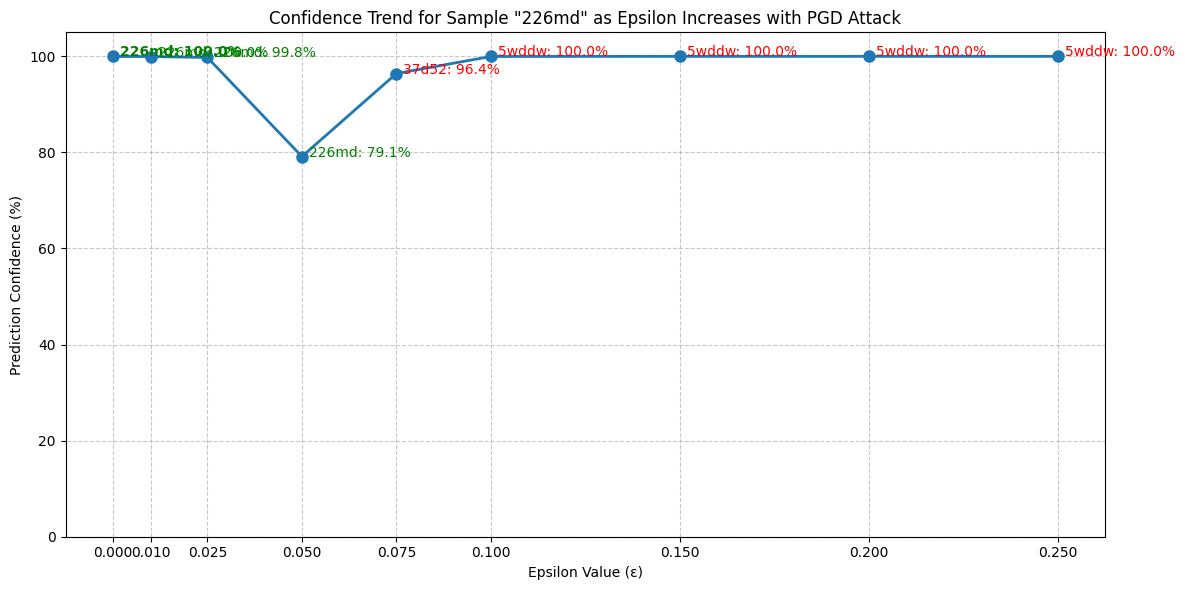

In [15]:
sample_idx = 0  # Choose one sample for detailed analysis
sample_image = test_images[sample_idx]
true_label = label_encoder.inverse_transform([test_labels[sample_idx]])[0]

# Get clean prediction and confidence
clean_pred = model.predict(np.expand_dims(sample_image, axis=0))
clean_pred_idx = np.argmax(clean_pred)
clean_pred_label = label_encoder.inverse_transform([clean_pred_idx])[0]
clean_confidence = clean_pred[0][clean_pred_idx] * 100

# Create a range of epsilon values
detailed_eps_values = [0, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25]
confidences = []
predictions = []

for eps in detailed_eps_values:
    if eps == 0:  # Clean image
        adv_image = np.expand_dims(sample_image, axis=0)
    else:
        attack_pgd = ProjectedGradientDescent(
            estimator=classifier,
            eps=eps,
            eps_step=eps/10,
            max_iter=40,
            targeted=False,
            num_random_init=1
        )
        adv_image = attack_pgd.generate(x=np.expand_dims(sample_image, axis=0))
    
    pred = model.predict(adv_image)
    pred_idx = np.argmax(pred)
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = pred[0][pred_idx] * 100
    
    confidences.append(confidence)
    predictions.append(pred_label)

# Plot confidence trend
plt.figure(figsize=(12, 6))
plt.plot(detailed_eps_values, confidences, 'o-', linewidth=2, markersize=8)

for i, (eps, conf, pred) in enumerate(zip(detailed_eps_values, confidences, predictions)):
    color = 'green' if pred == clean_pred_label else 'red'
    plt.annotate(f"{pred}: {conf:.1f}%", 
                xy=(eps, conf), 
                xytext=(5, 0), 
                textcoords="offset points",
                color=color,
                fontweight='bold' if i == 0 else 'normal')

plt.xlabel('Epsilon Value (ε)')
plt.ylabel('Prediction Confidence (%)')
plt.title(f'Confidence Trend for Sample "{true_label}" as Epsilon Increases with PGD Attack')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(detailed_eps_values)
plt.ylim(0, 105)

plt.tight_layout()
plt.show()

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 58ms/step
Epsilon: 0.01
Adversarial Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


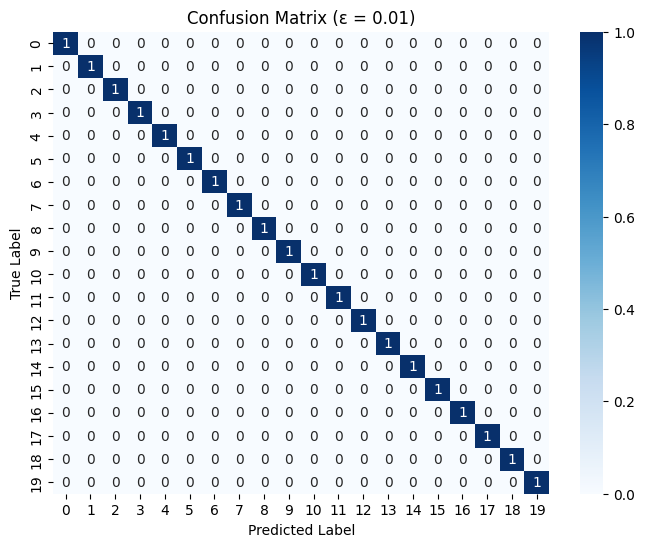

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 67ms/step
Epsilon: 0.05
Adversarial Accuracy: 0.2000
Precision: 0.1250
Recall: 0.1250
F1 Score: 0.1250


C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:24: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)
C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:28: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(cm) / np.sum(cm, axis=1)


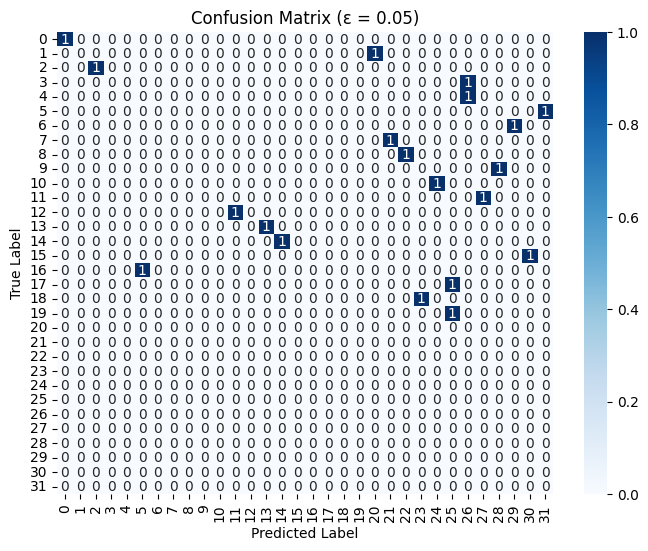

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 60ms/step
Epsilon: 0.1
Adversarial Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:24: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)
C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:28: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(cm) / np.sum(cm, axis=1)


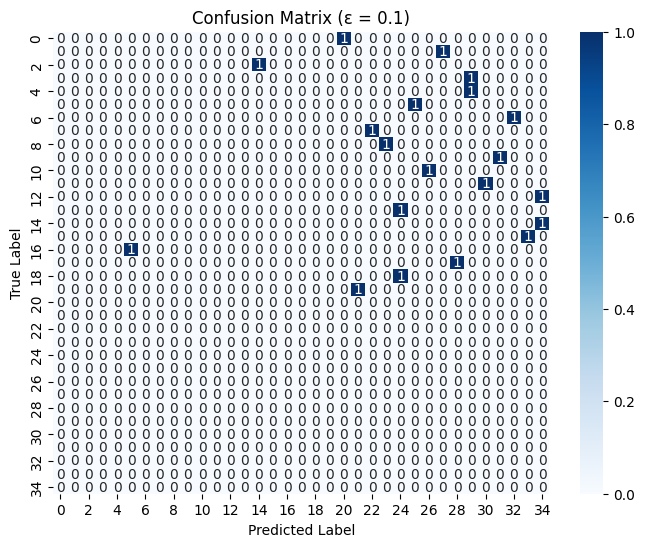

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 72ms/step
Epsilon: 0.15
Adversarial Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:24: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)
C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:28: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(cm) / np.sum(cm, axis=1)


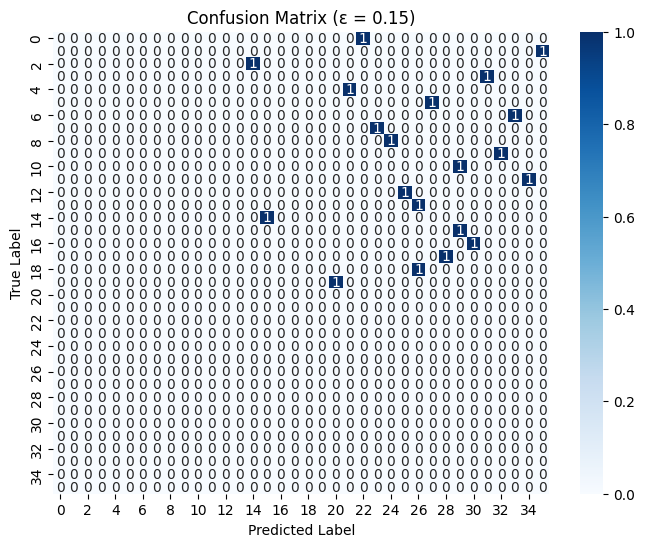

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 76ms/step
Epsilon: 0.2
Adversarial Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:24: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)
C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:28: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(cm) / np.sum(cm, axis=1)


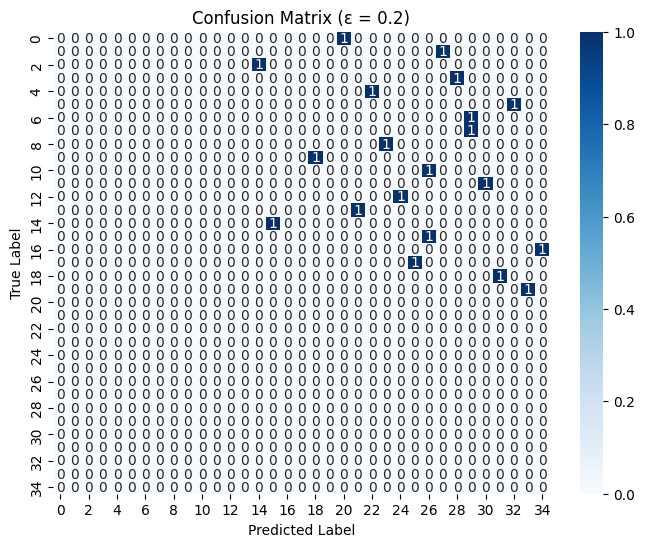

PGD - Batches: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 55ms/step
Epsilon: 0.25
Adversarial Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:24: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)
C:\Users\palla\AppData\Local\Temp\ipykernel_31884\2452291941.py:28: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(cm) / np.sum(cm, axis=1)


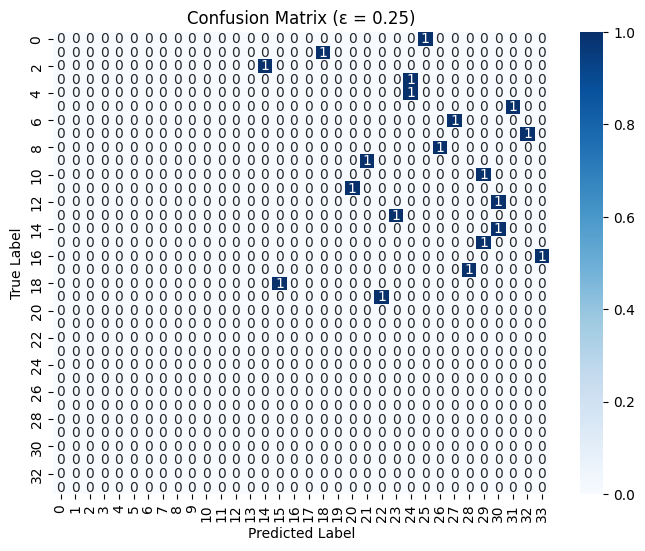

In [16]:
# Add this after your existing code that calculates accuracy
# For each epsilon value, calculate and display additional metrics
for eps in eps_values:
    attack_pgd = ProjectedGradientDescent(
        estimator=classifier,
        eps=eps,
        eps_step=eps/10,
        max_iter=40,
        targeted=False,
        num_random_init=1
    )
    
    test_images_adv = attack_pgd.generate(x=test_images)
    
    # Get predictions
    adv_preds = model.predict(test_images_adv)
    adv_pred_classes = np.argmax(adv_preds, axis=1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_labels, adv_pred_classes)
    
    # Calculate precision, recall, and F1 score (macro-averaged)
    # For multi-class, we'll use macro averaging
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision = np.nan_to_num(precision)  # Replace NaN with 0
    macro_precision = np.mean(precision)
    
    recall = np.diag(cm) / np.sum(cm, axis=1)
    recall = np.nan_to_num(recall)  # Replace NaN with 0
    macro_recall = np.mean(recall)
    
    # Calculate F1 score
    f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0
    
    print(f"Epsilon: {eps}")
    print(f"Adversarial Accuracy: {np.mean(adv_pred_classes == test_labels):.4f}")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (ε = {eps})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [17]:
try:
    # Try to load FGSM results from a previous run
    with open("fgsm_results.pkl", "rb") as f:
        fgsm_results = pickle.load(f)
    
    # Plot comparison
    plt.figure(figsize=(12, 7))
    
    # PGD results
    pgd_eps = [r[0] for r in results]
    pgd_acc = [r[1] * 100 for r in results]
    plt.plot(pgd_eps, pgd_acc, 'o-', linewidth=2, markersize=8, label='PGD Attack')
    
    # FGSM results
    fgsm_eps = [r[0] for r in fgsm_results]
    fgsm_acc = [r[1] * 100 for r in fgsm_results]
    plt.plot(fgsm_eps, fgsm_acc, 's--', linewidth=2, markersize=8, label='FGSM Attack')
    
    plt.axhline(y=clean_accuracy * 100, color='green', linestyle='--', 
                label=f'Clean Accuracy: {clean_accuracy * 100:.2f}%')
    
    plt.xlabel('Epsilon Value (ε)', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Comparison of PGD vs FGSM Attack Effectiveness', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(eps_values)
    
    plt.tight_layout()
    plt.show()
except:
    print("FGSM results not found for comparison. Run FGSM notebook first and save results.")
    # Save current PGD results for future comparison
    with open("pgd_results.pkl", "wb") as f:
        pickle.dump(results, f)

FGSM results not found for comparison. Run FGSM notebook first and save results.
